<a href="https://colab.research.google.com/github/johannes-kk/am207/blob/master/exercises/12_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAY 12: Interpreting and Evaluating Logistic Regression Models


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: October 13th, 11:59pm EST

**Names of Group Members**:\
Hayden Sansum (hayden_sansum@g.harvard.edu) \
Gabriel Pestre (gpestre@g.harvard.edu) \
William Seaton (wseaton@g.harvard.edu) \
Owen Callen (owencallen@gmail.com) \
Johannes Kolberg (johanneskolberg@g.harvard.edu) \
Matthieu Meeus (matthieu_meeus@g.harvard.edu)


## Learning Goals:

1. Gain intuition for how to formulate scientific hypothesis based on statistical models with covariates.
2. Explore how to evaluate the predicitiveness of logistic regression models
2. Explore how to evaluate the predictive uncertainties of logistic regression models


### Load necessary libraries

In [ ]:
# !pip install pymc3==3.8
# !pip install arviz

### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from pymc3 import model_to_graphviz, Model
import pymc3 as pm
%matplotlib inline

     |████████████████████████████████| 911kB 2.7MB/s 
     |████████████████████████████████| 1.5MB 14.6MB/s 
     |████████████████████████████████| 727kB 21.2MB/s 
     |████████████████████████████████| 4.3MB 31.7MB/s 
     |████████████████████████████████| 296kB 38.6MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


### We include auxiliary functions here that we will need to use later 

In [ ]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       model - the 'sklearn' classification model
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    interval = np.arange(-4, 4.1, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 1.
        linewidths=0.5
        
    i = 0
    
    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        ax.contourf(x1, x2, yy, alpha=0.2 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)
        
        i += 1
        
    ax.set_xlim((-4, 4))
    ax.set_ylim((-4, 4))
    ax.set_xlabel('marker 1')
    ax.set_ylabel('marker 2')
    ax.legend(loc='best')
    return ax

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def predict(self, x):
        y = sigmoid(x.dot(self.slopes) + self.intercept)
        return (y > 0.5).astype(np.int_)

## Problem Description: Modeling Preterm Births

You are given the birth mother data (normalized) for approximately 2,000 new borns in California between the years 2000 and 2001 (`lab_6_data.csv`). Previous studies have indicated that demographic factors of the birth mother strongly affects the risk of preterm births (preterm here means a gestational age of less than 37 weeks). Your task is to investigate whether or not this assertion holds for the dataset at hand. 

### **Modeling for Testing Scientific Hypotheses**
We can investigate our hypothesis -- that demographic factors of the birth mother strongly affects the risk of preterm births -- in multiple ways:

**Exercise 1:** Visualize the joint distribution of the covariates -- color preterm births differently than the full term births. From the way the data looks, is there any evidence to support our hypothesis?

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/onefishy/am207/master/Labs/datasets/birth_data.csv')
df.head()

,mothers income (normalized),mothers age (normalized),preterm
0,-0.400228,-0.926880,0
1,1.076102,1.180291,1
2,-0.922953,0.306167,0
3,0.897991,2.407370,1
4,1.506738,2.583626,1


In [ ]:
X = df[['mothers income (normalized)', 'mothers age (normalized)']].values
y = df['preterm'].values

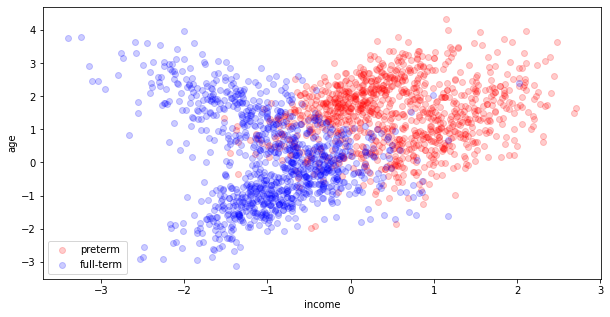

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='preterm', alpha=0.2)
ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='full-term', alpha=0.2)
ax.set_xlabel('income')
ax.set_ylabel('age')
ax.legend(loc='best')
plt.show()

From the chart above there does appear to be evidence that demographic factors (in this case income and age) have an impact on preterm births. The data can be split into two different groupings based on the factors with some unspecified overlap.

**Exercise 2:** Visualize marginal distribution of the covariates. For each covariate, make two histograms on the same plot, one for preterm births, another for full-term births. From the way the marginals look, is there any evidence to support our hypothesis?

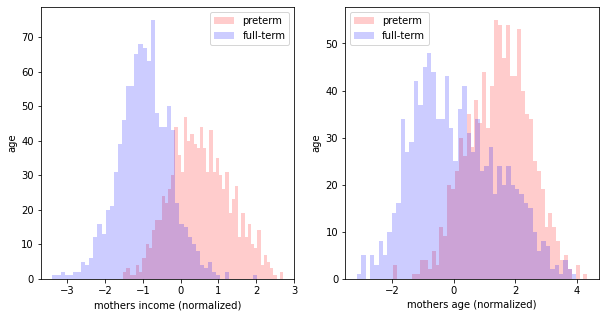

In [ ]:
# colors = ['red', 'blue']
# plt.hist(df['mothers age (normalized)'], 30, density=True, histtype='bar', color=colors, label=df['preterm'])

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.hist(df[df['preterm']==1].iloc[:,0], bins=50, color='red', label='preterm', alpha=0.2)
ax1.hist(df[df['preterm']==0].iloc[:,0], bins=50, color='blue', label='full-term', alpha=0.2)
ax1.set_xlabel(df.columns[0])
ax1.set_ylabel('age')
ax1.legend(loc='best')

ax2.hist(df[df['preterm']==1].iloc[:,1], bins=50, color='red', label='preterm', alpha=0.2)
ax2.hist(df[df['preterm']==0].iloc[:,1], bins=50, color='blue', label='full-term', alpha=0.2)
ax2.set_xlabel(df.columns[1])
ax2.set_ylabel('age')
ax2.legend(loc='best')

plt.show() 

Based on the marginals, there is also evidence to support our hypothesis. We can see the mode and means for the two distributions differs and therefore we might expect these factors have an impact on preterm birth.

**Exercise 3:** In the lecture notes for logistic regression, we showed that fitting a logistic regression model to explain Bernoulli outcomes is the same as fitting a hyperplane (a decision boundary) to separate (or classify) two classes of data in covariate-space. Use `sklearn`'s logistic regression model (set the parameter `C` to be large), to find the MLE of the coefficients of a logistic regression model for this dataset.

In [ ]:
logreg = LogisticRegression(C=1e15, fit_intercept=True).fit(X,y)


**Exercise 4:** Extract and interpret the MLE coefficients found by your `sklearn` model (`coef_`, `intercept_`). What do these coefficients tell you about the relationship between demographic factors of the birth mother and the risk of preterm birth?

In [ ]:
print(logreg.intercept_, logreg.coef_) 

[-0.19021562] [[3.12108716 1.38688646]]


From these coefficients we can infer that as normalized age increases there is a corresponding increase in the risk of preterm birth of 1.38. A single unit increase in normalized income has a large impact, corresponding to a 3.12 increase and the overall baserate is lower as can be seen from the intercept.

**Exercise 5:** Visualize the decision boundary of the MLE logistic regression model using the `plot_decision_boundary` function provided to you. What does this visualization tell you about the reliability of your conclusions about the relationship between demographic factors of the birth mother and the risk of preterm birth?<br><br>
  


In [ ]:
logistic = LogisticRegression(random_state=0, C=1e10, solver='lbfgs')
logistic.fit(X, y)

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

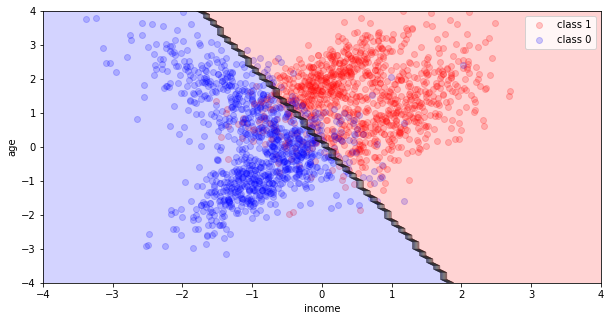

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(X, y, [logistic], ax, poly_degree=1)
ax.set_xlabel('income')
ax.set_ylabel('age')
ax.legend(loc='best')
plt.show()

Given the clear visual split between classes and the relatively few samples that cross the dividing line, we could feel relatively confident that a relationship exists between demographic factors and risk of preterm birth, though we should always be wary of relying exclusively on visual analysis. 

### **Model Evaluation**

There are multiple ways to evaluate your logistic regression model:

**Exercise 6:** One way is to predict or classify data points as preterm or full term depending on the $\theta^{(n)}$ that your model predicts for the $n$-th observation. You can then evaluate the predictive accuracy (use `sklearn`'s `.score()` function). What does the predictive accuracy of your model tell you about the reliability of your conclusions about the relationship between demographic factors of the birth mother and the risk of preterm birth?

In [ ]:
logreg.score(X,y)

0.8935

THe accuracy here is very high BUT we need to be aware that this is on the training data which is not a robust method for testing accuracy as it does not account for the fact that our model could be overfit.

**Exercise 7:** Another way to evaluate your model is to look at the actual probabilities $\theta^{(n)}$'s that it predicts. We bin the observations according to the value of $\theta^{(n)}$ predicted by the model, for a fixed bin ( $a<\theta^{(n)}<b$ ) we compute the actual percentage of observations that have label $y=1$ and compare with the predicted percentage $\theta_n$. We say a model is miscalibrated if the predicted percentage is consistently different from the actual. We can plot the actual percentage against the predicted in a ***calibration plot*** (use `sklearn.calibration.calibration_curve`). 

What's wrong with an 'over-calibrated model', what kind of mistakes might we make if we interpret the classification probabilites $\theta^{(n)}$? What's wrong with an 'under-calibrated model', what kind of mistakes might we make if we interpret the classification probabilities? 

What does your calibration plot say about your model?

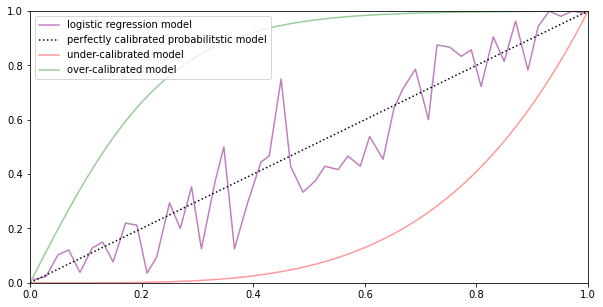

In [ ]:
prob_pos = logistic.predict_proba(X)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y, prob_pos, n_bins=50)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(mean_predicted_value, fraction_of_positives, color='purple', alpha=0.5, label='logistic regression model')
ax.plot([0, 1], [0, 1], 'k:', label='perfectly calibrated probabilitstic model')
x = np.linspace(0, 1, 100)
ax.plot(x, x**4, color='red', alpha=0.4, label='under-calibrated model')
ax.plot(x, 2. / (1 + np.exp(-8 * x)) - 1, color='green', alpha=0.4, label='over-calibrated model')
ax.legend(loc='upper left')
ax.set_ylim((0, 1))
ax.set_xlim((0, 1))
plt.show()

What the calibration plot is showing us is how well the predicted probabilities align with the true probability in the data at different regions of predictions. The theoretical ideal is the diagonal - where the actual percentage of ones in a given region matches the predicted probability within that region.

We see that the logistic regression model performs very well in that it is very close to the perfectly calibrated model.

The problem with an overcalibrated model is that it overpredicts the percentage of a preterm birth - looking at a true underlying 0.5 percentage of preterm birth (from the data) the predicted probability is almost 1.0 (almost certain). On the flip side for under calibrated models it is almost zero.

**Exercise 8:** Evaluating a single MLE model fitted on the observed data gives you no sense of how sensitive the model is to small changes in the data. We can easily test our model's sensitivity. Bootstrapping your data, fit 100 MLE logistic regression models. Compute the mean MLE coefficients (averaged over 100 bootstrap estimates). What do these coefficients tell you about the relationship between demographic factors of the birth mother and the risk of preterm birth?

In [ ]:
# Prepare parameters
bootstraps = 100
coefs = []
for i in range(bootstraps):
    # Bootstrap data
    X_boot, y_boot = sk.utils.resample(X,y, replace=True)
    
    # Fit MLE Logistic Regression
    logistic = LogisticRegression(random_state=0, C=1e10, solver='lbfgs').fit(X_boot, y_boot)
    
    # Save coefficients
    coefs.append(logistic.coef_)

# Print Mean MLE Coefficient
print("Mean MLE: ", np.mean(coefs, axis=0)) 

Mean MLE:  [[3.1379388  1.39469073]]


These coefficients are similar to our previously fitted single MLE estimate for the model - the relationship between coefficients and preterm birth are the same and it doesn't appear that sensitive.

**Exercise 9:** We've already examined one source of uncertainty from a logistic model: the classification probability. There is another source of uncertainty: uncertainty over the model itself as we slightly change (bootstrap the training data).

Visualize the decision boundaries of all of these boostrap MLE models. 

How does uncertainty over the decision boundary relate to the uncertainty represented by the classification probability? Do they tell you the same things about your model/data or different things?

What does this visualization tell you about the reliability of your conclusions about the relationship between demographic factors of the birth mother and the risk of preterm birth?

Is the uncertainty over the decision boundary desirable -- that is, does it help us determine where the model is unreliable and must be overriden by a human expert? 

***Hint:*** given the input (5, 5), would the bootstrap predictive uncertainty for this point be high or low? Show it be high or low?

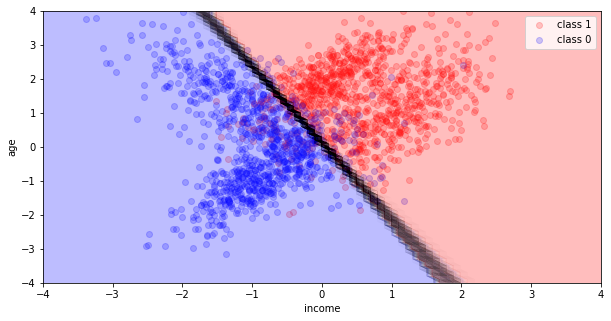

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
models = []

for i in range(100):
    bootstrap_indices = np.random.choice(np.arange(0, len(y)), size=len(y))
    X_bootstrap = X[bootstrap_indices]
    y_bootstrap = y[bootstrap_indices]
    logistic = LogisticRegression(random_state=0, C=1e10, solver='lbfgs')
    logistic.fit(X_bootstrap, y_bootstrap)
    models.append(logistic)

ax = plot_decision_boundary(X, y, models, ax, poly_degree=1)
ax.set_xlabel('income')
ax.set_ylabel('age')
ax.legend(loc='best')
plt.show()

There appears greater uncertainty over the relationship in data-poor regions, which does reflect that we're more uncertain on the relationship between the covariates and preterm births in these locations. This is useful when evaluating the parameters of the linear model, but it is not necessarily useful in evaluating whether the linear model is the appropriate split for this data. In the center of our plot (at 0,0), this is the area where there is the greatest overlap in class 1 and class 0 data points. We could reasonably say there is more uncertainty in that location as to whether or not a new born will be a preterm birth, but our uncertainty measurements here wouldn't be reflecting the classification uncertainty, only the fit uncertainty.

**Exercise 10 (Optional):** Generalize logistic regression for polynomial boundaries, that is, transform the input using a polynomial feature map and perform logistic regression. 

Repeat the above: evaluate the predictiveness of the model, interpret the regression coefficients, plot the bootstrap uncertainty over boundaries. In this case, do we gain anything by increasing the complexity of our model? Do we lose anything?

---

### **A Bayesian Approach**

Repeat all of the above for a Bayesian logistic regression model of your data. In particular, compare the uncertainty estimation:

**Exercise 11:** Compare the uncertainty from the bootstrap MLE and the uncertainty from the posterior of the Bayesian model, are the uncertanties different? Is this expected?

Which type of uncertainty is more reliable or informative? Why?

In [ ]:
with pm.Model() as bayesian_model:
    #define priors
    slopes = pm.Normal('slopes', mu=0, tau=1./50, shape=2)
    intercept = pm.Normal('intercept', mu=0, tau=1./50)
    
    #define linear model, using marital status as a covariate
    mu = intercept + pm.math.dot(X, slopes) 
    
    #transform linear model into a probability
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    #define binomial likelihood
    y_observed = pm.Bernoulli('y_obs',  p=theta, observed=y)

    trace = pm.sample(4000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [intercept, slopes]
Sampling chain 1, 0 divergences: 100%|██████████| 6000/6000 [00:18<00:00, 321.11it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


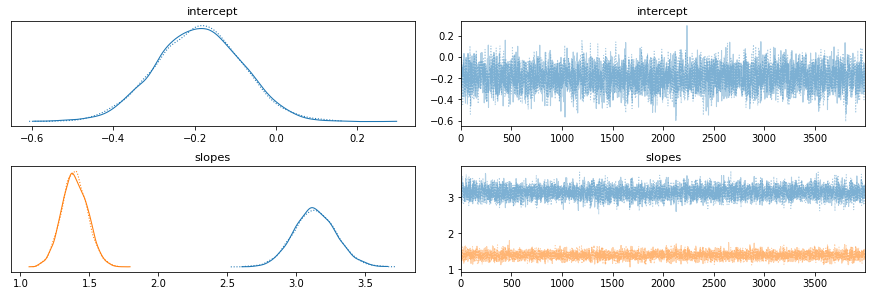

In [ ]:
pm.traceplot(trace, var_names= ['intercept', 'slopes'])
plt.show()

In [ ]:
thinned_trace = trace[::10]
posterior_samples_index = np.random.choice(np.arange(len(thinned_trace)), size=100)
models = []

for index in posterior_samples_index:
    sample = thinned_trace[index]
    model = Bayesian_logistic_regression(sample['intercept'], sample['slopes'])
    models.append(model)

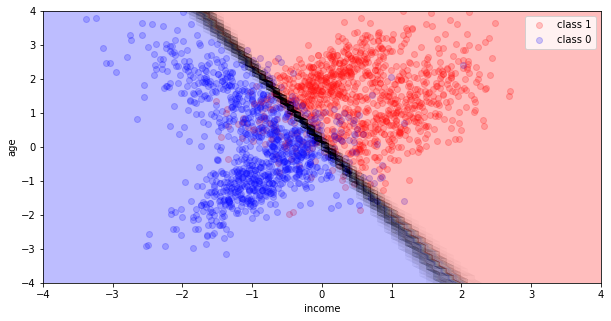

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(X, y, models, ax, poly_degree=1)
ax.set_xlabel('income')
ax.set_ylabel('age')
ax.legend(loc='best')
plt.show()

The uncertainties do not appear materially different, in that they are both narrower in the middle and wider at the edges. The Bayes model appears to have wider points at the end that overlap more potentially-blue-in-red points within the uncertainty bounds. This might be desirable, but it is tough to draw too steep a difference.

**Exercise 12 (Optional):** Perform Bayesian logistic regression with a polynomial boundary - i.e. first transform the data using a polynomial feature map and then perform Bayesian logistic regression. Are the boundary uncertainties for the Bayesian model different from the bootstrap uncertainties? Is this expected?

---
### **Data Heterogeneity**

Recall from the many examples from lecture and homework that it is often useful to break up the data into categories and fit a model for each category. This is especially true if the variations in the data is heterogeneous. 

**Exercise 13:** Look at the our data, is there any heterogeneity in the data? Do you think there would be any benefit in break up the data and fitting separate models for each subset? Why or why not?

In [ ]:
df.head()

,mothers income (normalized),mothers age (normalized),preterm
0,-0.400228,-0.926880,0
1,1.076102,1.180291,1
2,-0.922953,0.306167,0
3,0.897991,2.407370,1
4,1.506738,2.583626,1


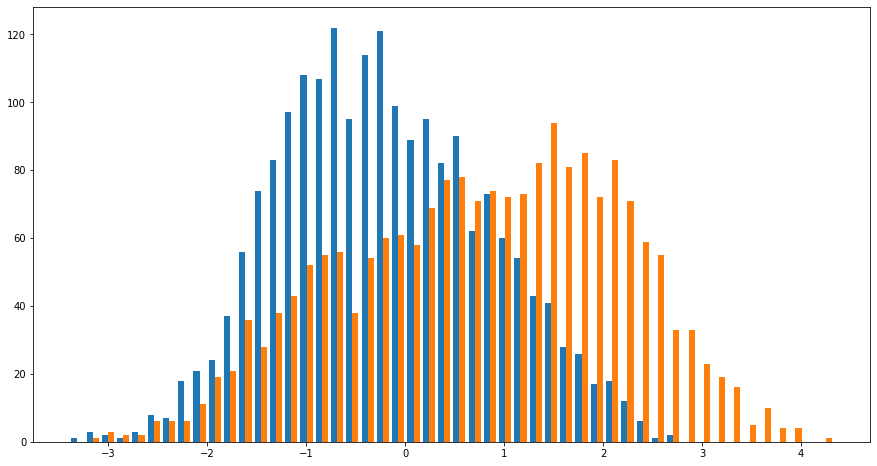

In [ ]:
plt.figure(figsize=(15,8))
plt.hist(X, bins=50);

Distributing the values over a sufficiently detailed bucket level, it appears that income is a fairly homogenous normal distribution. Age at a sufficientl level of detail might be multimodal, with potential peaks around -1, 0.3 and 1.5 on its normalized x-axis. There also appears to be two nearly perpendicular trend lines in the class 0 data on our decision boundary plot. Paired together, this might be suggestive of it being worth splitting the data at least once and fitting to each to improve predictive accuracy.

**Exercise 14:** In the case of the kidney cancer data set, it was easy to break up the data into categories based on the county. If we wanted to break up this dataset, how would we do it? Justify your answer.

We could add a latent variable that is calculated based on chosen logic. That logic could be simple, like applying manual income/age separation logic based on a visual analysis of the X/Y plot, or it could be complex like deploying an unsupervised clustering algorithm across the data and applying the cluster count as labels.